In [1]:
from lnm import LNMDataset, PandasDatasetLoader
import numpy as np
import pandas as pd

# Load the participant data
participant_data = pd.read_csv('example_data/participants.csv')

# Filter for Broca and NoAphasia
filtered_df = participant_data[participant_data['wab_type'].isin(['Broca', 'NoAphasia'])].copy()

# Create a case-control column (1 for Broca, 0 for NoAphasia)
filtered_df['case_control'] = (filtered_df['wab_type'] == 'Broca').astype(int)

# Define paths
output_dir = '/Users/jiturner/Repositories/lnm-toolkit/joseph_output/feb18'

# Load data using PandasDatasetLoader
loader = PandasDatasetLoader(
    df=filtered_df,
    subject_col='subject',
    network_col='t',
    mask_col='roi_2mm',
)
data = loader.load()

# Create the dataset
ds = LNMDataset(
    networks=data.networks,
    mask_img=data.mask_img,
    roi_masks=data.roi_masks,
    output_prefix=output_dir,
    control_roi_volume=True,
    control_roi_centrality=True, 
    add_intercept=True,
    design_matrix=filtered_df['case_control'].values,
    contrast_matrix=np.array([1, 0, 0, 0]),  # Test case-control contrast
    cases_control_labels=filtered_df['case_control'].values,
    n_permutations=100
)
ds.load_data()

# Run GLM analysis
results = ds.network_glm_analysis()

/Users/jiturner/Repositories/lnm-toolkit/lnm/loaders.py:31: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mask_img = math_img("np.where(img != 0, 1, 0)", img=mean_img(networks))
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/nilearn/image/image.py:1160: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


--- Processing Contrast c1 (1/1) ---


In [6]:
from prism.stats import t
import numpy as np
from prism.datasets import Dataset

# t_result, _, _ = t(
#     ds.network_data,
#     ds.design_matrix,
#     ds.contrast_matrix,
# )
# t_result



# Y = np.random.randn(100, 50)        # Brain data (samples x voxels)
# X = np.random.randn(100, 2)         # Design matrix
# C = np.array([1, -1])               # Contrast

# dataset = Dataset(
#     data=Y,
#     design=X,
#     contrast=C,
#     demean=True, # On simulated data, this doesn't affect the results one way or the other.
#     n_permutations=100, 
# )

# But here, I'm gonna use real data, and when I set demean=True, I get -inf and inf values.

dataset = Dataset(
    data=ds.network_data,
    design=ds.design_matrix,
    contrast=ds.contrast_matrix,
    n_permutations=100, 
    demean=False, # if I set demean=False, it works great! Only when demean=True do I get -inf and inf values.
)

results_ = dataset.permutation_analysis()
results_['tstat'] # Only -inf, and inf values.

np.corrcoef(ds.design_matrix[:, 1], ds.design_matrix[:, 2]) # The correlation is -0.81, should I be worried about this?

--- Processing Contrast c1 (1/1) ---


array([[ 1.        , -0.88785091],
       [-0.88785091,  1.        ]])

<Axes: >

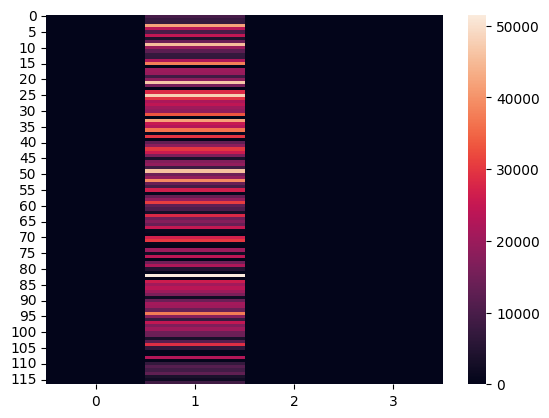

In [10]:
import seaborn as sns
sns.heatmap(ds.design_matrix)

In [ ]:
from prism.stats import demean_glm_data

Y_d, X_d, C_d, _ = demean_glm_data(ds.network_data, ds.design_matrix, ds.contrast_matrix)

# Check condition number — anything above ~1e10 is trouble
print(np.linalg.cond(X_d))

# Check rank vs shape
print(np.linalg.matrix_rank(X_d), X_d.shape)

# Check if X'X is invertible
XtX = X_d.T @ X_d
print(np.linalg.det(XtX))  # near-zero = singular

In [ ]:
import pandas as pd

df = pd.read_excel('/Users/jiturner/Documents/Stats_BrainMet_SRS_ICI_Order.xlsx')
primary_division_column = 'ici_order_conc' # 1, 2, or 0 

,patient_id,prior_srs_surg,date_met_diag,date_melanoma_diagnosis,date_first_srs,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,ici_order_all,...,min_dose,mean_dose,margin_dose,V12Gy,PID,BRAF,BRAF_targeted,steroids,prior_BRT,AEI
0,TJH001,0.0,NaT,NaT,NaT,NaN,NaN,NaT,NaN,1.0,...,27.5,44,30.0,44.771,50.0,NaN,NaN,NaN,NaN,NaN
1,TJH002,0.0,NaT,NaT,NaT,NaN,NaN,NaT,NaN,1.0,...,21.9,28.2,22.0,1.654,75.0,NaN,NaN,NaN,NaN,NaN
2,TJH003,0.0,NaT,NaT,NaT,NaN,NaN,NaT,NaN,1.0,...,25.5,44.5,30.0,67.684,50.0,NaN,NaN,NaN,NaN,NaN
3,AHN001,0.0,2026-10-24,2026-11-24,2026-11-24,NaN,NaN,NaT,NaN,1.0,...,25.1,41.9,30.0,NaN,50.0,NaN,NaN,1.0,0,diarrhea
4,AHN002,0.0,2026-06-25,2026-06-25,2026-06-25,NaN,NaN,NaT,NaN,1.0,...,24.7,37.6,27.0,NaN,50.0,1.0,0.0,1.0,0,"pruritis, arthralgias"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Yal024,0.0,2026-12-15,2026-11-06,2026-03-18,"8/2015, 11/2015, 8/2017",NaN,2026-05-19,2026-02-18 00:00:00,0.0,...,22.7,32.1,22.0,NaN,50.0,0.0,NaN,0.0,0,NaN
223,Yal025,0.0,2026-07-18,2026-01-18,2026-08-18,"1/2018, 6/2018",2026-06-18 00:00:00,2026-05-19,2026-09-18 00:00:00,0.0,...,27.0,38,22.0,NaN,50.0,0.0,NaN,0.0,1,NaN
224,Yal031,0.0,2026-05-20,2026-08-18,2026-06-20,"11/2018, 3/2019, 12/2019, 12/2019, 3/2020,",2026-03-20 00:00:00,2026-10-21,2026-11-20 00:00:00,0.0,...,24.2,30.4,22.0,NaN,60.0,0.0,NaN,0.0,0,NaN
225,Yal032,0.0,2026-12-20,2026-12-20,2026-01-21,"7/2020, 12/2020",2026-12-20 00:00:00,2026-12-21,2026-03-21 00:00:00,0.0,...,18.0,25,22.0,NaN,50.0,0.0,NaN,0.0,0,NaN
